In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [7]:
df = pd.read_csv('D:/mental_health_detector/data/raw/depression_dataset_reddit_cleaned.csv')

In [8]:
print("Shape:", df.shape)
print("Columns:", df.columns)

# Show sample rows
df.head(5)

Shape: (7731, 2)
Columns: Index(['clean_text', 'is_depression'], dtype='object')


,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [9]:
df.info()

# Count null values in each column
print("Missing values:\n", df.isnull().sum())

# as we found from the dataset- there is no null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB
Missing values:
 clean_text       0
is_depression    0
dtype: int64


In [10]:
# Distribution of target variable
print("Label distribution:")
print(df['is_depression'].value_counts())
print(df['is_depression'].value_counts(normalize=True))

##3900 people are there which do not have depresion and 3831 are there who are depressed

Label distribution:
is_depression
0    3900
1    3831
Name: count, dtype: int64
is_depression
0    0.504463
1    0.495537
Name: proportion, dtype: float64


Text length stats:
 count    7731.000000
mean       74.647394
std       144.378243
min         1.000000
25%        12.000000
50%        22.000000
75%        76.000000
max      4239.000000
Name: text_length, dtype: float64


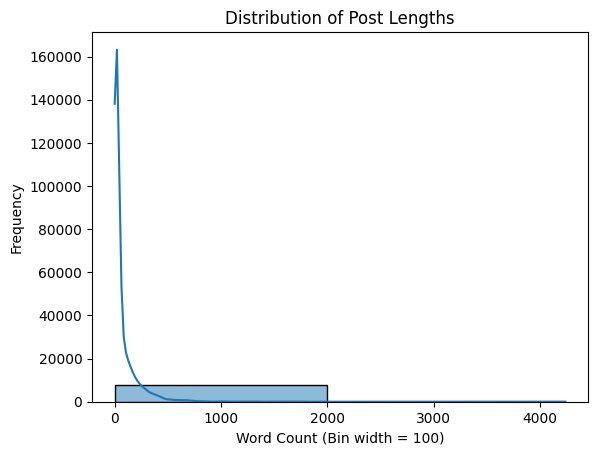

In [23]:
# Analyze length of posts
df['text_length'] = df['clean_text'].apply(lambda x: len(str(x).split()))
print("Text length stats:\n", df['text_length'].describe())
# Calculate maximum text length to define bin edges
max_length = df['text_length'].max()
bins = np.arange(0, max_length + 1000, 2000)  # Creates bins of width 100 up to max length

sns.histplot(df['text_length'], bins=bins, kde=True)
plt.title("Distribution of Post Lengths")
plt.xlabel("Word Count (Bin width = 100)")
plt.ylabel("Frequency")
plt.show()

In [18]:
# Print a few sample posts for each class
for label in df['is_depression'].unique():
    print(f"\nLabel: {label}")
    samples = df[df['is_depression'] == label]['clean_text'].sample(5, random_state=42)
    for text in samples:
        print("----")
        print(text[:400])  # Print first 400 chars for brevity



Label: 1
----
i m not depressed or in depression i think there is a lot to live for in life actually but lately i ve been having thought of suicide it s not every hour of every day but something will happen and i ll just casually think to myself what the hell f ck this and fast forward to when i m dead i have every reason to live i have a roof over my head food on the table and a small circle of friend a job so
----
i used to enjoy posting and just interacting with people but now i can t bring myself to open it up it s just awful seeing post and post of people just living while i m just existing stagnant it all feel so counterfeit
----
content warning od throwing up hi this is just a vent ig but like last night i really felt like taking an overdose but i decided not to so that i didn t have to throw up cause that happened and i hate it and i don t want to throw up and then die like that would be awful but today i woke up at like three or four am and puked all over the floor and now i 

In [27]:


# Download resources (only once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()                                   # Lowercase
    text = re.sub(r"http\S+|www\S+", '', text)                 # Remove URLs
    text = re.sub(r"<.*?>", " ", text)                         # Remove HTML tags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = text.split()
    words = [w for w in words if w.isalpha()]                  # Remove numbers & non-alphabetic
    words = [w for w in words if w not in stop_words]          # Remove stopwords
    words = [lemmatizer.lemmatize(w) for w in words]           # Lemmatize
    return ' '.join(words)

df['processed_text'] = df['clean_text'].apply(preprocess_text)

# Optionally, check a few processed samples
df[['clean_text', 'processed_text']].head(5)


[nltk_data] Downloading package stopwords to C:\Users\vishal
[nltk_data]     kumar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\vishal
[nltk_data]     kumar\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\vishal
[nltk_data]     kumar\AppData\Roaming\nltk_data...


,clean_text,processed_text
0,we understand that most people who reply immed...,understand people reply immediately op invitat...
1,welcome to r depression s check in post a plac...,welcome r depression check post place take mom...
2,anyone else instead of sleeping more when depr...,anyone else instead sleeping depressed stay ni...
3,i ve kind of stuffed around a lot in my life d...,kind stuffed around lot life delaying inevitab...
4,sleep is my greatest and most comforting escap...,sleep greatest comforting escape whenever wake...


In [28]:
import os

# Create directory if it doesn't exist
output_dir = 'D:/mental_health_detector/data/processed'
os.makedirs(output_dir, exist_ok=True)

# Define output file path
output_path = os.path.join(output_dir, 'depression_dataset_processed.csv')

# Save the DataFrame to the specified path without the index column
df.to_csv(output_path, index=False)

print(f"Dataset saved to {output_path}")


Dataset saved to D:/mental_health_detector/data/processed\depression_dataset_processed.csv


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate the vectorizer (adjust max_features as needed for large datasets)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the processed text column
X_tfidf = vectorizer.fit_transform(df['processed_text'])

# Show shape of resulting feature matrix
print("TF-IDF matrix shape:", X_tfidf.shape)

# (Optional) Access feature names for interpretation
feature_names = vectorizer.get_feature_names_out()
print("Sample features:", feature_names[:20])


TF-IDF matrix shape: (7731, 5000)
Sample features: ['aa' 'ab' 'abandoned' 'abandonment' 'ability' 'able' 'able find'
 'able get' 'able go' 'absence' 'absolute' 'absolutely'
 'absolutely nothing' 'abt' 'abuse' 'abused' 'abusive'
 'abusive relationship' 'academic' 'accept']


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) # Adjust max_features as needed

# Fit and transform processed text
X_tfidf = vectorizer.fit_transform(df['processed_text'])

# Display shape of TF-IDF matrix
print("TF-IDF feature matrix shape:", X_tfidf.shape)

# Optionally, view some feature names
print("Sample feature names:", vectorizer.get_feature_names_out()[:20])


TF-IDF feature matrix shape: (7731, 5000)
Sample feature names: ['aa' 'ab' 'abandoned' 'abandonment' 'ability' 'able' 'able find'
 'able get' 'able go' 'absence' 'absolute' 'absolutely'
 'absolutely nothing' 'abt' 'abuse' 'abused' 'abusive'
 'abusive relationship' 'academic' 'accept']


In [31]:
from sklearn.model_selection import train_test_split

# Assuming TF-IDF features are stored in X_tfidf and labels in y
y = df['is_depression']

# Split data: 80% training, 20% testing, with fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Label distribution in train: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Label distribution in test: {y_test.value_counts(normalize=True).to_dict()}")


Training samples: 6184, Test samples: 1547
Label distribution in train: {0: 0.5045278137128072, 1: 0.49547218628719275}
Label distribution in test: {0: 0.5042016806722689, 1: 0.4957983193277311}


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Optional: Detailed classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9560
Precision: 0.9807
Recall: 0.9296
F1-Score: 0.9545

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96       780
           1       0.98      0.93      0.95       767

    accuracy                           0.96      1547
   macro avg       0.96      0.96      0.96      1547
weighted avg       0.96      0.96      0.96      1547

Confusion Matrix:
 [[766  14]
 [ 54 713]]
